In [2]:
import numpy as np
from scipy.stats import t as t_law
import matplotlib.pyplot as plt
from tqdm import tqdm 
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.linear_model import LinearRegression, Ridge
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']
s_colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']

In [4]:
data = pd.read_csv("GasolineMarket.csv")
data

,OBS,GC,PG,RI,RPN,RPT,RPU
0,1970,6.714227,-0.100947,2.943489,0.311872,-0.097374,-0.218002
1,1971,6.765328,-0.137221,2.985432,0.309661,-0.068993,-0.204794
2,1972,6.830206,-0.156660,3.033986,0.268967,-0.061672,-0.233363
3,1973,6.847757,-0.123892,3.093292,0.210451,-0.111888,-0.232193
4,1974,6.697846,0.074440,3.079637,0.160793,-0.194156,-0.295147
5,1975,6.732342,0.053035,3.089182,0.156273,-0.212513,-0.205640
6,1976,6.780673,0.037742,3.128747,0.161904,-0.174270,-0.123290
7,1977,6.809115,0.031026,3.165322,0.149898,-0.192272,-0.102431
8,1978,6.822789,0.000000,3.209507,0.150639,-0.235878,-0.155686
9,1979,6.725719,0.194642,3.215122,0.119312,-0.279452,-0.187293


In [5]:
def off_2sls(stage1, stage2, Z, X1, X2, y):
    stage1.fit(Z, X1)
    hatX1 = stage1.predict(Z)
    X = np.concatenate([hatX1, X2], axis=1)
    stage2.fit(X, y)
    haty = stage2.predict(X)
    return stage1, stage2, haty, stage1.coef_, stage2.coef_

def off_2sls(stage1, stage2, Z, X1, X2, y):
    stage1.fit(Z, X1)
    hatX1 = stage1.predict(Z)
    X = np.concatenate([hatX1, X2], axis=1)
    stage2.fit(X, y)
    haty = stage2.predict(X)
    return stage1, stage2, haty, stage1.coef_, stage2.coef_

def o2sls(data, t, compare_model="linear", alpha=0.1):
    data = data.head(t)
    Z = np.array(data[["RPT", "RPN", "RPU", "RI"]]) 
    X1 = np.array(data["PG"]).reshape((-1,1))
    X2 = np.array(data["RI"]).reshape((-1,1))
    y = np.array(data["GC"]).reshape((-1,1))

    # Declare and fit comparison models
    if compare_model == 'ridge':
        stage1 = Ridge(alpha)
        stage2 = Ridge(alpha)
    elif compare_model == 'linear':
        stage1 = LinearRegression()
        stage2 = LinearRegression()

    return off_2sls(stage1, stage2, Z, X1, X2, y)
    

T = len(data.index)

betas = [] 

for t in range(1,T+1,1):
    stage1, stage2, haty, coef1, coef2 = o2sls(data, t, compare_model="ridge", alpha=0.01)
    betas.append(coef2[0])

betas = np.array(betas)
betas

array([[ 0.        ,  0.        ],
       [-0.01026924,  0.09841666],
       [-0.08132368,  0.36799007],
       [-0.05269639,  0.50631078],
       [-0.4604026 ,  0.43091821],
       [-0.48390766,  0.44112027],
       [-0.4519918 ,  0.46469839],
       [-0.4493047 ,  0.51708647],
       [-0.47684264,  0.5316112 ],
       [-0.51221554,  0.53304501],
       [-0.49111768,  0.52209795],
       [-0.50699064,  0.54542407],
       [-0.55793921,  0.5677376 ],
       [-0.55681444,  0.55718446],
       [-0.5570036 ,  0.5426731 ],
       [-0.57797252,  0.57051141],
       [-0.63772638,  0.59356519],
       [-0.62431107,  0.54482137],
       [-0.6227374 ,  0.51536047],
       [-0.63005886,  0.5124051 ],
       [-0.63382915,  0.52266567],
       [-0.63644349,  0.51768527],
       [-0.63411193,  0.50007596],
       [-0.62979154,  0.49342384],
       [-0.63171315,  0.49429708],
       [-0.63715228,  0.49880743],
       [-0.64355788,  0.50691162],
       [-0.64668169,  0.51150607],
       [-0.64989203,

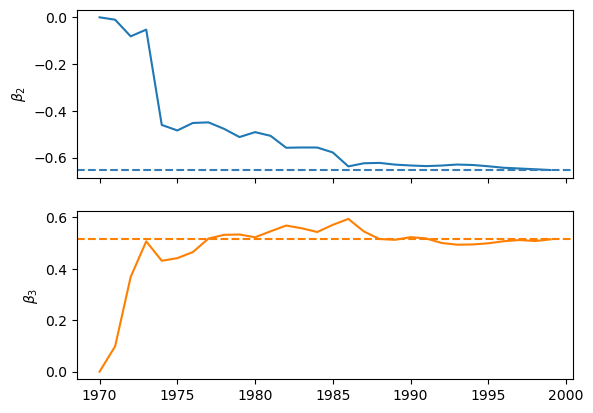

In [6]:
# Two subplots, the axes array is 1-d

years = np.array(data["OBS"])
b2 = betas[:,0]
b3 = betas[:,1]

f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(years, b2)
axarr[0].set_ylabel(r"$\beta_2$")
axarr[0].axhline(y=b2[-1], color=colors[0], linestyle='--')

axarr[1].plot(years, b3, color=colors[1])
axarr[1].set_ylabel(r"$\beta_3$")
axarr[1].axhline(y=b3[-1], color=colors[1], linestyle='--')


# plt.figure(figsize = (6,4))
# plt.plot(np.array(data["OBS"])[1:],betas)
# plt.axhline(y=betas[-1,0], color=colors[0], linestyle='--')
# plt.xlabel("Year")
# plt.ylabel(r"$\beta_2$")
plt.savefig("./gasoline.pdf", format='pdf')

# Supply and Demand

In [7]:
data = pd.read_csv("SupplyDemand.csv")

In [10]:
X = np.array(data[["PRICE0", "PRICE1", "PRICE5", "PRICE10"]]).reshape((-1,4))
y = np.array(data[["SALES0_0", "SALES0_1", "SALES0_5", "SALES0_10"]]).reshape((-1,4))
dim_s_f=4

sp = LinearRegression()
for i in range(dim_s_f):
    sp.fit(X[:,i].reshape((-1,1)), y[:,i].reshape((-1,1)))
    print(sp.score(X[:,i].reshape((-1,1)), y[:,i].reshape((-1,1))).round(3))
    print(sp.coef_[0][0].round(3))

0.794
-0.976
0.808
-0.966
0.93
-0.973
0.977
-0.985


In [11]:
X = np.array(data[["PRICE0", "PRICE0", "PRICE0", "PRICE0"]]).reshape((-1,4))
y = np.array(data[["SALES0_0", "SALES1_0", "SALES5_0", "SALES10_0"]]).reshape((-1,4))

sp = LinearRegression()
for i in range(dim_s_f):
    sp.fit(X[:,i].reshape((-1,1)), y[:,i].reshape((-1,1)))
    print(sp.score(X[:,i].reshape((-1,1)), y[:,i].reshape((-1,1))).round(3))
    print(sp.coef_[0][0].round(3))

0.794
-0.976
0.718
-0.969
0.243
-0.942
0.076
-0.909


In [12]:
X = np.array(data[["PRICE0", "PRICE1", "PRICE5", "PRICE10"]]).reshape((-1,4))
y = np.array(data[["SALES0_0", "SALES1_1", "SALES5_5", "SALES10_10"]]).reshape((-1,4))

sp = LinearRegression()
for i in range(dim_s_f):
    sp.fit(X[:,i].reshape((-1,1)), y[:,i].reshape((-1,1)))
    print(sp.score(X[:,i].reshape((-1,1)), y[:,i].reshape((-1,1))).round(3))
    print(sp.coef_[0][0].round(3))

0.794
-0.976
0.706
-0.874
0.214
-0.273
0.064
-0.085


# New dataset for Supply and Demand

In [43]:
## PARAMETERS 
n_iters = 50
T = int(1e3)
sigma_1, sigma_2 = 1, 1 
lamda, lamda_IV = 1e-2, 1e-2 
methods = ['Ridge','O2SLS' 'Oracle']  
online_loss_oracle = np.zeros((n_iters, len(methods), T))
online_loss_identification = np.zeros((n_iters, len(methods), T))

np.random.seed(23)
s = np.array([0,1,5,10]).reshape(1,1,4)
f = np.array([0,1,5,10]).reshape(1,4)
theta_star = 1
beta_star = -1.
type_offrec = [r"$\beta_t$", r"$R^2_t$", r"$regret$"]
dim_s_f = 4

In [44]:
# MODEL 
# first stage
e = np.random.binomial(1, 0.01, size=(T,1,))
Z = np.random.randn(T,1)
eps = sigma_1*np.random.randn(T,1)
Xmat = 5 + theta_star*Z + f*e + eps
# second stage
# eta = eta_tilde + np.linalg.norm(eps, axis=1)  
eta = sigma_2*np.random.randn(T,1,1) 
Ymat = 100 + beta_star*Xmat[:,:,np.newaxis] + e[:,np.newaxis,:]*s + eta
# axis0 = T, axis1 = f, axis2 = s 

# ## MODEL 
# # first stage
# e = np.random.binomial(1, 0.01, size=(n_iters, T,1))
# Z = np.random.randn(n_iters,T,1)
# eps = sigma_1*np.random.randn(n_iters,T,1)
# Xmat = 5 + theta_star*Z + f*e + eps
# # second stage
# # eta = eta_tilde + np.linalg.norm(eps, axis=1)  
# eta = sigma_2*np.random.randn(n_iters, T,1,1) 
# Ymat = 100 + beta_star*Xmat[:,:,:,np.newaxis] + e[:,:,np.newaxis,:]*s + eta
# # axis0 = T, axis1 = f, axis2 = s 

#### Study of the different endogeneity settings:

#### s = 0 $\rightarrow$ no endogeneneity but much bigger variance in prices $\rightarrow$ no problem estimating $\beta$

In [15]:
# X = Xmat 
# y = Ymat[:,:,0]
# 
# sp = LinearRegression()
# for i in range(dim_s_f):
#     sp.fit(X[:,i].reshape((-1,1)), y[:,i].reshape((-1,1)))
#     print("R^2 \t=\t", sp.score(X[:,i].reshape((-1,1)), y[:,i].reshape((-1,1))).round(3))
#     print("beta \t=\t", sp.coef_[0][0].round(3))


X = Xmat 
y = Ymat[:,:,:,0]

records_off_s_0 = np.zeros((n_iters, len(type_offrec), dim_s_f))

sp = LinearRegression()
for e in range(n_iters):
    for i in range(dim_s_f):
        sp.fit(X[e,:,i].reshape((-1,1)), y[e,:,i].reshape((-1,1)))
        records_off_s_0[e, 0, i] = sp.coef_[0][0]
        records_off_s_0[e, 1, i] = sp.score(X[e,:,i].reshape((-1,1)), y[e,:,i].reshape((-1,1)))
        records_off_s_0[e, 2, i] = np.abs(records_off_s_0[e, 0, i]-beta_star)
    # print("R^2 \t=\t", sp.score(X[:,i].reshape((-1,1)), y[:,i].reshape((-1,1))).round(3))
    # print("beta \t=\t", sp.coef_[0][0].round(3))

average_beta_s_0 = np.mean(records_off_s_0[:,0,:], axis=0)
std_beta_s_0 = np.std(records_off_s_0[:,0,:], axis=0)
average_r2_s_0 = np.mean(records_off_s_0[:,1,:], axis=0)
std_r2_s_0 = np.std(records_off_s_0[:,1,:], axis=0)
average_reg_s_0 = np.mean(records_off_s_0[:,2,:], axis=0)
std_reg_s_0 = np.std(records_off_s_0[:,2,:], axis=0)

print("beta = ", average_beta_s_0, "±", std_beta_s_0)
print("r2 = ", average_r2_s_0, "±", std_r2_s_0)
print("regret = ", average_reg_s_0, "±", std_reg_s_0)

beta =  [-1.00454545 -1.00450247 -1.00389662 -1.00279333] ± [0.02010662 0.01986984 0.01778517 0.01439351]
r2 =  [0.66757719 0.66867146 0.69281874 0.74863853] ± [0.01763357 0.01773511 0.0200924  0.02765912]
regret =  [0.01630292 0.01615544 0.01477829 0.01194699] ± [0.01261554 0.01241308 0.01063474 0.00849972]


In [16]:
XXmat = np.repeat(Xmat[:,:,:,np.newaxis], dim_s_f,axis=-1) 
X = XXmat[:,:,:,0]
y = Ymat[:,:,:,0]

records_off_s_0 = np.zeros((n_iters, len(type_offrec), dim_s_f))

sp = LinearRegression()
for e in range(n_iters):
    for i in range(dim_s_f):
        sp.fit(X[e,:,i].reshape((-1,1)), y[e,:,i].reshape((-1,1)))
        records_off_s_0[e, 0, i] = sp.coef_[0][0]
        records_off_s_0[e, 1, i] = sp.score(X[e,:,i].reshape((-1,1)), y[e,:,i].reshape((-1,1)))
        records_off_s_0[e, 2, i] = np.abs(records_off_s_0[e, 0, i]-beta_star)
    # print("R^2 \t=\t", sp.score(X[:,i].reshape((-1,1)), y[:,i].reshape((-1,1))).round(3))
    # print("beta \t=\t", sp.coef_[0][0].round(3))

average_beta_s_0 = np.mean(records_off_s_0[:,0,:], axis=0)
std_beta_s_0 = np.std(records_off_s_0[:,0,:], axis=0)
average_r2_s_0 = np.mean(records_off_s_0[:,1,:], axis=0)
std_r2_s_0 = np.std(records_off_s_0[:,1,:], axis=0)
average_reg_s_0 = np.mean(records_off_s_0[:,2,:], axis=0)
std_reg_s_0 = np.std(records_off_s_0[:,2,:], axis=0)

print("beta = ", average_beta_s_0, "±", std_beta_s_0)
print("r2 = ", average_r2_s_0, "±", std_r2_s_0)
print("regret = ", average_reg_s_0, "±", std_reg_s_0)


print(np.mean(records_off_s_0[:,:,:], axis=0))


beta =  [-1.00454545 -1.00450247 -1.00389662 -1.00279333] ± [0.02010662 0.01986984 0.01778517 0.01439351]
r2 =  [0.66757719 0.66867146 0.69281874 0.74863853] ± [0.01763357 0.01773511 0.0200924  0.02765912]
regret =  [0.01630292 0.01615544 0.01477829 0.01194699] ± [0.01261554 0.01241308 0.01063474 0.00849972]
[[-1.00454545 -1.00450247 -1.00389662 -1.00279333]
 [ 0.66757719  0.66867146  0.69281874  0.74863853]
 [ 0.01630292  0.01615544  0.01477829  0.01194699]]


#### f = 0 $\rightarrow$ no endogeneneity but much bigger variance in second stage $\rightarrow$ high variance unexplained see $R^2$

In [17]:
# X = np.tile(Xmat[:,0].reshape(-1,1), (1,4)) 
# y = Ymat[:,0,:]

# sp = LinearRegression()
# for i in range(dim_s_f):
#     sp.fit(X[:,i].reshape((-1,1)), y[:,i].reshape((-1,1)))
#     print("R^2 \t=\t", sp.score(X[:,i].reshape((-1,1)), y[:,i].reshape((-1,1))).round(3))
#     print("beta \t=\t", sp.coef_[0][0].round(3))


X = np.repeat(Xmat[:,:,0, np.newaxis], dim_s_f, axis=-1)
y = Ymat[:,:,0,:]

records_off_f_0 = np.zeros((n_iters, len(type_offrec), dim_s_f))

sp = LinearRegression()
for e in range(n_iters):
    for i in range(dim_s_f):
        sp.fit(X[e,:,i].reshape((-1,1)), y[e,:,i].reshape((-1,1)))
        records_off_f_0[e, 0, i] = sp.coef_[0][0]
        records_off_f_0[e, 1, i] = sp.score(X[e,:,i].reshape((-1,1)), y[e,:,i].reshape((-1,1)))
        records_off_f_0[e, 2, i] = np.abs(records_off_f_0[e, 0, i]-beta_star)
    # print("R^2 \t=\t", sp.score(X[:,i].reshape((-1,1)), y[:,i].reshape((-1,1))).round(3))
    # print("beta \t=\t", sp.coef_[0][0].round(3))

average_beta_f_0 = np.mean(records_off_f_0[:,0,:], axis=0)
std_beta_f_0 = np.std(records_off_f_0[:,0,:], axis=0)
average_r2_f_0 = np.mean(records_off_f_0[:,1,:], axis=0)
std_r2_f_0 = np.std(records_off_f_0[:,1,:], axis=0)
average_reg_f_0 = np.mean(records_off_f_0[:,2,:], axis=0)
std_reg_f_0 = np.std(records_off_f_0[:,2,:], axis=0)

print("beta = ", average_beta_f_0, "±", std_beta_f_0)
print("r2 = ", average_r2_f_0, "±", std_r2_f_0)
print("regret = ", average_reg_f_0, "±", std_reg_f_0)

beta =  [-1.00454545 -1.00453626 -1.0044995  -1.00445355] ± [0.02010662 0.01985177 0.02162718 0.02858549]
r2 =  [0.66757719 0.66533467 0.6163315  0.50350027] ± [0.01763357 0.0169052  0.0208327  0.04432004]
regret =  [0.01630292 0.0159315  0.01735192 0.02373888] ± [0.01261554 0.01268297 0.01367082 0.01653572]


#### f = s = 0, 1, 5, 10 $\rightarrow$ endogeneity appears due to the event "e"

In [45]:
X = Xmat
y = np.array([np.diag(Ymat[i,:,:]) for i in range(T)]) 

sp = LinearRegression()
for i in range(dim_s_f):
    sp.fit(X[:,i].reshape((-1,1)), y[:,i].reshape((-1,1)))
    print("R^2 \t=\t", sp.score(X[:,i].reshape((-1,1)), y[:,i].reshape((-1,1))).round(3))
    print("beta \t=\t", sp.coef_[0][0].round(3))

R^2 	=	 0.648
beta 	=	 -0.986
R^2 	=	 0.646
beta 	=	 -0.979
R^2 	=	 0.574
beta 	=	 -0.854
R^2 	=	 0.425
beta 	=	 -0.619


#### eliminate endogeneity with IV

In [46]:
def off_2sls_ds(stage1, stage2, Z, X, y):
    stage1.fit(Z, X)
    hatX = stage1.predict(Z)
    stage2.fit(hatX, y)
    haty = stage2.predict(X)
    return stage1, stage2

stage1 = LinearRegression()
stage2 = LinearRegression()

for i in range(dim_s_f):
    stage1, stage2 = off_2sls_ds(stage1, stage2, Z, X[:,i].reshape((-1,1)), y[:,i].reshape((-1,1)))
    print("R^2 \t=\t", stage2.score(X[:,i].reshape((-1,1)), y[:,i].reshape((-1,1))).round(3))
    print("beta \t=\t", stage2.coef_[0][0].round(3))


R^2 	=	 0.648
beta 	=	 -1.008
R^2 	=	 0.646
beta 	=	 -1.007
R^2 	=	 0.556
beta 	=	 -1.003
R^2 	=	 0.265
beta 	=	 -0.998


# Online version

In [19]:
def off_2sls_ds(stage1, stage2, Z, X, y):
    stage1.fit(Z, X)
    hatX = stage1.predict(Z)
    stage2.fit(hatX, y)
    haty = stage2.predict(X)
    return stage1, stage2 #, haty, stage1.coef_, stage2.coef_
    

type_records= [r"$\beta_t$", r"$R^2_t$", r"$\ell_t$"]
dim_s_f = 4
n_ev = 20


#### s = 0 $\rightarrow$ no endogeneneity but much bigger variance in prices $\rightarrow$ no problem estimating $\beta$

In [20]:
X = Xmat 
y = Ymat[:,:,0]

sp = Ridge(10)
records_s_0 = np.zeros((n_ev, T, len(type_records), dim_s_f))

for e in range(n_ev):
    for t in range(1,T,1):
        for i in range(dim_s_f):
            sp.fit(X[:t,i].reshape((-1,1)), y[:t,i].reshape((-1,1)))
            records_s_0[t, 0 ,i] = sp.coef_[0][0]
            if t>1:
                records_s_0[t, 1 ,i] = sp.score(X[:t,i].reshape((-1,1)), y[:t,i].reshape((-1,1)))
            if t<T-1:
                records_s_0[t, 2 ,i] = (sp.predict(X[t+1,i].reshape((-1,1)))-y[t+1,i])**2
            # records_s_0[t, 3 ,i] = records_s_0[t, 2 ,i]-(X[t+1,i]*beta_star-y[t+1,i])

ValueError: could not broadcast input array from shape (4,4) into shape (4,)

In [21]:
# records_s_0

ValueError: x and y must have same first dimension, but have shapes (1000,) and (20, 4)

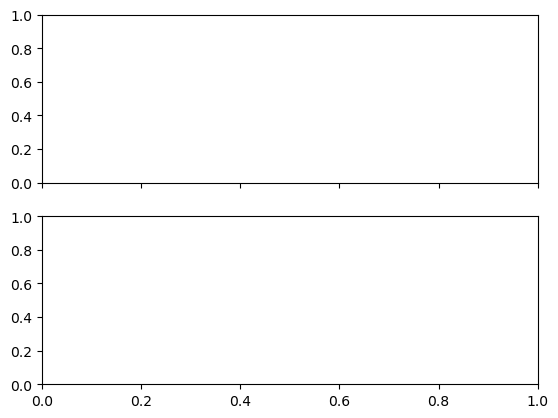

In [22]:
rounds = np.array([t for t in range(1,T+1,1)])
b2 = betas[:,0]
b3 = betas[:,1]


f, axarr = plt.subplots(2, sharex=True)
for i in range(dim_s_f):
    b = records_s_0[:, 0, i]
    r = records_s_0[:, 1, i]
    axarr[0].plot(rounds, b, label = i)
    axarr[0].set_ylabel(type_records[0])
    axarr[0].legend()
    # axarr[0].axhline(y=b2[-1], color=colors[0], linestyle='--')

    axarr[1].plot(rounds, r)#, color=colors[1])
    axarr[1].set_ylabel(type_records[1])
    # axarr[1].axhline(y=b3[-1], color=colors[1], linestyle='--')


plt.savefig("./s_0.pdf", format='pdf')

#### f = 0 $\rightarrow$ no endogeneneity but much bigger variance in second stage $\rightarrow$ high variance unexplained see $R^2$

In [ ]:
X = np.tile(Xmat[:,0].reshape(-1,1), (1,4)) 
y = Ymat[:,0,:]

sp = LinearRegression()
for i in range(dim_s_f):
    sp.fit(X[:,i].reshape((-1,1)), y[:,i].reshape((-1,1)))
    print("R^2 \t=\t", sp.score(X[:,i].reshape((-1,1)), y[:,i].reshape((-1,1))).round(3))
    print("beta \t=\t", sp.coef_[0][0].round(3))

R^2 	=	 0.648
beta 	=	 -0.986
R^2 	=	 0.646
beta 	=	 -0.983
R^2 	=	 0.587
beta 	=	 -0.971
R^2 	=	 0.453
beta 	=	 -0.956


In [ ]:
X = np.tile(Xmat[:,0].reshape(-1,1), (1,4)) 
y = Ymat[:,0,:]

sp = Ridge(10)
records_f_0 = np.zeros((T, len(type_records), dim_s_f))


for t in range(1,T,1):
    for i in range(dim_s_f):
        sp.fit(X[:t,i].reshape((-1,1)), y[:t,i].reshape((-1,1)))
        records_f_0[t, 0 ,i] = sp.coef_[0][0]
        if t>1:
            records_f_0[t, 1 ,i] = sp.score(X[:t,i].reshape((-1,1)), y[:t,i].reshape((-1,1)))
        if t<T-1:
            records_f_0[t, 2 ,i] = (sp.predict(X[t+1,i].reshape((-1,1)))-y[t+1,i])**2
        # records_f_0[t, 3 ,i] = records_f_0[t, 2 ,i]-(X[t+1,i]*beta_star-y[t+1,i])

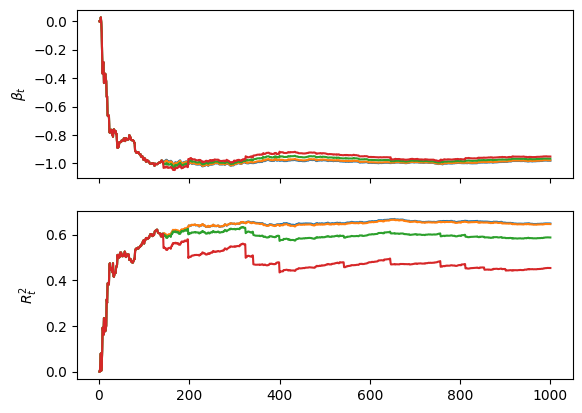

In [ ]:
# records_f_0[:, 0, 0]


rounds = np.array([t for t in range(1,T+1,1)])
b2 = betas[:,0]
b3 = betas[:,1]


f, axarr = plt.subplots(2, sharex=True)
for i in range(dim_s_f):
    b = records_f_0[:, 0, i]
    r = records_f_0[:, 1, i]
    axarr[0].plot(rounds, b)
    axarr[0].set_ylabel(type_records[0])
    # axarr[0].axhline(y=b2[-1], color=colors[0], linestyle='--')

    axarr[1].plot(rounds, r)#, color=colors[1])
    axarr[1].set_ylabel(type_records[1])
    # axarr[1].axhline(y=b3[-1], color=colors[1], linestyle='--')


plt.savefig("./f_0.pdf", format='pdf')

#### f = s = 0, 1, 5, 10 $\rightarrow$ endogeneity appears due to the event "e"

In [ ]:
X = Xmat
y = np.array([np.diag(Ymat[i,:,:]) for i in range(T)]) 

sp = LinearRegression()
for i in range(dim_s_f):
    sp.fit(X[:,i].reshape((-1,1)), y[:,i].reshape((-1,1)))
    print("R^2 \t=\t", sp.score(X[:,i].reshape((-1,1)), y[:,i].reshape((-1,1))).round(3))
    print("beta \t=\t", sp.coef_[0][0].round(3))

R^2 	=	 0.648
beta 	=	 -0.986
R^2 	=	 0.646
beta 	=	 -0.979
R^2 	=	 0.574
beta 	=	 -0.854
R^2 	=	 0.425
beta 	=	 -0.619


In [ ]:
X = Xmat
y = np.array([np.diag(Ymat[i,:,:]) for i in range(T)]) 

sp = Ridge(10)
records_sf = np.zeros((T, len(type_records), dim_s_f))


for t in range(1,T,1):
    for i in range(dim_s_f):
        sp.fit(X[:t,i].reshape((-1,1)), y[:t,i].reshape((-1,1)))
        records_sf[t, 0 ,i] = sp.coef_[0][0]
        if t>1:
            records_sf[t, 1 ,i] = sp.score(X[:t,i].reshape((-1,1)), y[:t,i].reshape((-1,1)))
        if t<T-1:
            records_sf[t, 2 ,i] = (sp.predict(X[t+1,i].reshape((-1,1)))-y[t+1,i])**2
        # records_f_0[t, 3 ,i] = records_f_0[t, 2 ,i]-(X[t+1,i]*beta_star-y[t+1,i])

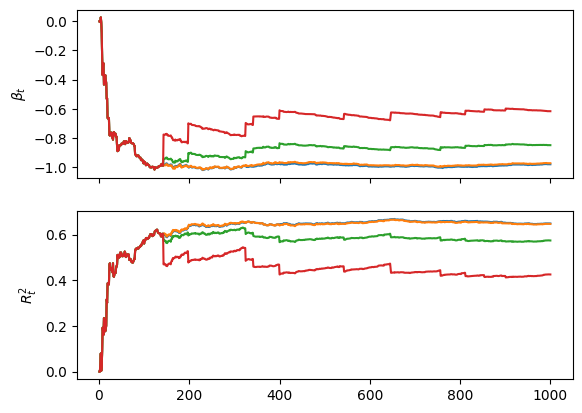

In [ ]:
rounds = np.array([t for t in range(1,T+1,1)])
b2 = betas[:,0]
b3 = betas[:,1]


f, axarr = plt.subplots(2, sharex=True)
for i in range(dim_s_f):
    b = records_sf[:, 0, i]
    r = records_sf[:, 1, i]
    axarr[0].plot(rounds, b)
    axarr[0].set_ylabel(type_records[0])
    # axarr[0].axhline(y=b2[-1], color=colors[0], linestyle='--')

    axarr[1].plot(rounds, r)#, color=colors[1])
    axarr[1].set_ylabel(type_records[1])
    # axarr[1].axhline(y=b3[-1], color=colors[1], linestyle='--')


plt.savefig("./sf_01510.pdf", format='pdf')

#### eliminate endogeneity with IV

In [ ]:
def off_2sls_ds(stage1, stage2, Z, X, y):
    stage1.fit(Z, X)
    hatX = stage1.predict(Z)
    stage2.fit(hatX, y)
    haty = stage2.predict(X)
    return stage1, stage2 #, haty, stage1.coef_, stage2.coef_

# stage1 = LinearRegression()
# stage2 = LinearRegression()

stage1 = Ridge(lamda_IV)
stage2 = Ridge(lamda_IV)

records_sf_IV = np.zeros((T, len(type_records), dim_s_f))


# for i in range(dim_s_f):
#     stage1, stage2 = off_2sls_ds(stage1, stage2, Z, X[:,i].reshape((-1,1)), y[:,i].reshape((-1,1)))
#     print("R^2 \t=\t", stage2.score(X[:,i].reshape((-1,1)), y[:,i].reshape((-1,1))).round(3))
#     print("beta \t=\t", stage2.coef_[0][0].round(3))


for t in range(1,T,1):
    for i in range(dim_s_f):
        stage1, stage2 = off_2sls_ds(stage1, stage2, Z[:t], X[:t,i].reshape((-1,1)), y[:t,i].reshape((-1,1)))
        records_sf[t, 0 ,i] = stage2.coef_[0][0]
        if t>1:
            # records_sf[t, 1 ,i] = stage2.score(stage1.predict(X[:t,i].reshape((-1,1))), y[:t,i].reshape((-1,1)))
            records_sf[t, 1 ,i] = stage2.score(X[:t,i].reshape((-1,1)), y[:t,i].reshape((-1,1)))
        if t<T-1:
            records_sf[t, 2 ,i] = (stage2.predict(X[t+1,i].reshape((-1,1)))-y[t+1,i])**2
        # records_f_0[t, 3 ,i] = records_f_0[t, 2 ,i]-(X[t+1,i]*beta_star-y[t+1,i])


-1.008
0.648400054500359
-1.007
0.6463049738902358
-1.003
0.5567765400111113
-0.998
0.26598237439295336


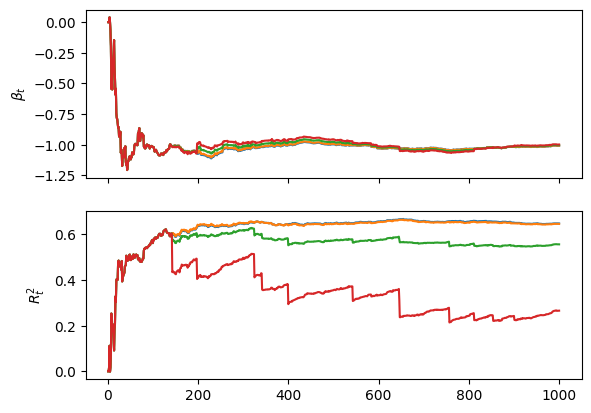

In [ ]:
rounds = np.array([t for t in range(1,T+1,1)])
b2 = betas[:,0]
b3 = betas[:,1]


f, axarr = plt.subplots(2, sharex=True)
for i in range(dim_s_f):
    b = records_sf[:, 0, i]
    r = records_sf[:, 1, i]
    axarr[0].plot(rounds, b)
    axarr[0].set_ylabel(type_records[0])
    # axarr[0].axhline(y=b2[-1], color=colors[0], linestyle='--')
    print(records_sf[-1, 0, i].round(3))
    print(records_sf[-1, 1, i])

    axarr[1].plot(rounds, r)#, color=colors[1])
    axarr[1].set_ylabel(type_records[1])
    # axarr[1].axhline(y=b3[-1], color=colors[1], linestyle='--')

    # axarr[1].xlim(100, 1000)
    # axarr[0].xlim(100, 1000)

    # b = records_sf[100:, 0, i]
    # r = records_sf[100:, 1, i]
    # rounds_ = rounds[100:]
    # axarr[0].plot(rounds_, b)
    # axarr[0].set_ylabel(type_records[0])
    # # axarr[0].axhline(y=b2[-1], color=colors[0], linestyle='--')

    # axarr[1].plot(rounds_, r)#, color=colors[1])
    # axarr[1].set_ylabel(type_records[1])
    # # axarr[1].axhline(y=b3[-1], color=colors[1], linestyle='--')


plt.savefig("./sf_01510_IV.pdf", format='pdf')

# All together

In [148]:
import numpy as np
from scipy.stats import t as t_law
import matplotlib.pyplot as plt
from tqdm import tqdm 
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.linear_model import LinearRegression, Ridge
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']
s_colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']

type_onrec = [r"$\beta_t$", r"$R^2_t$", r"$regret$", r"Cumulative Regret"]

In [183]:
## PARAMETERS 
np.random.seed(23)
n_iters = 20
T = int(1e3)
sigma_1, sigma_2 = 1, 1 
lamda, lamda_IV = 1e-1, 1e-1 


###### ???? needed ????
# methods = ['Ridge','O2SLS' 'Oracle']  
# online_loss_oracle = np.zeros((n_iters, len(methods), T))
# online_loss_identification = np.zeros((n_iters, len(methods), T))

s=[0,5,10,50] #+[20*i for i in range(1,11,1)]
f=[0,5,10,50] #+[20*i for i in range(1,11,1)]
if len(s) == len(f):
    dim_s_f = len(s)
else:
    raise ValueError("not implented different arrays")

s = np.array(s).reshape(1,1,dim_s_f)
f = np.array(f).reshape(1,dim_s_f)
theta_star = 1
beta_star = -1.
type_offrec = [r"$\beta_t$", r"$R^2_t$", r"$regret$"]

In [184]:
## MODEL 
# first stage
e = np.random.binomial(1, 0.01, size=(n_iters, T,1))
# Z = np.random.randn(n_iters,T,1)*5
Z = np.random.randn(n_iters,T,1)
eps = sigma_1*np.random.randn(n_iters,T,1)
Xmat = 5 + theta_star*Z + f*e + eps
# second stage
eta = sigma_2*np.random.randn(n_iters, T,1,1) 
Ymat = 100 + beta_star*Xmat[:,:,:,np.newaxis] + e[:,:,np.newaxis,:]*s + eta

In [185]:
XXmat = np.repeat(Xmat[:,:,:,np.newaxis], dim_s_f,axis=-1) 
X = XXmat
y = Ymat

## Offline

#### OLS/ridge

In [186]:
sp = LinearRegression()
records_off = np.zeros((n_iters, len(type_offrec), dim_s_f, dim_s_f))

for e in range(n_iters):
    for i in range(dim_s_f):
        for j in range(dim_s_f):
            sp.fit(X[e,:,i,j].reshape((-1,1)), y[e,:,i,j].reshape((-1,1)))
            records_off[e, 0, i, j] = sp.coef_[0][0]
            records_off[e, 1, i, j] = sp.score(X[e,:,i,j].reshape((-1,1)), y[e,:,i,j].reshape((-1,1)))
            records_off[e, 2, i, j] = np.abs(records_off[e,0,i,j]-beta_star)
mean_records_off = np.mean(records_off, axis=0)
std_records_off = np.std(records_off, axis=0)


<Axes: >

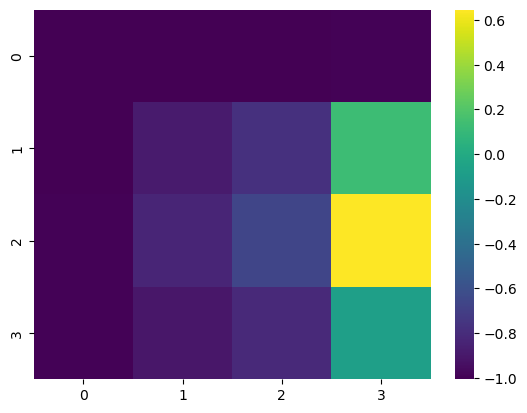

In [187]:
options = {"beta":0, "R2":1, "reg":2}
choose_key = "beta"

sns.heatmap(mean_records_off[options[choose_key],:,:], cmap="viridis")
# mean_records_off[options[choose_key],:,:].round(5)

#### IV

In [188]:
def off_2sls_ds(stage1, stage2, Z, X, y):
    stage1.fit(Z, X)
    hatX = stage1.predict(Z)
    stage2.fit(hatX, y)
    haty = stage2.predict(X)
    return stage1, stage2 

In [189]:
# stage1 = LinearRegression()
# stage2 = LinearRegression()
stage1 = Ridge(lamda_IV)
stage2 = Ridge(lamda_IV)

records_off_iv = np.zeros((n_iters, len(type_offrec), dim_s_f, dim_s_f))

for e in range(n_iters):
    for i in range(dim_s_f):
        for j in range(dim_s_f):
            stage1, stage2 = off_2sls_ds(stage1, stage2, Z[e,:,:], X[e,:,i,j].reshape((-1,1)), y[e,:,i,j].reshape((-1,1)))
            records_off_iv[e, 0, i, j] = stage2.coef_[0][0]
            records_off_iv[e, 1, i, j] = stage2.score(X[e,:,i,j].reshape((-1,1)), y[e,:,i,j].reshape((-1,1)))
            records_off_iv[e, 2, i, j] = np.abs(records_off_iv[e,0,i,j]-beta_star)

mean_records_iv = np.mean(records_off_iv[:,:,:,:], axis=0)
std_records_iv = np.std(records_off_iv, axis=0)

<Axes: >

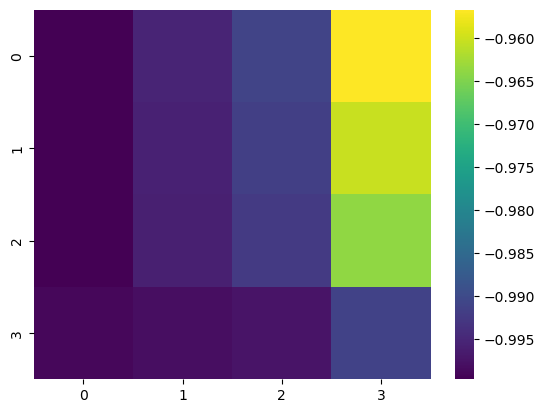

In [190]:
sns.heatmap(mean_records_iv[options[choose_key],:,:], cmap="viridis")
# mean_records_iv[options[choose_key],:,:].round(5)

Text(792.3131313131312, 0.5, '$\\rho_S$')

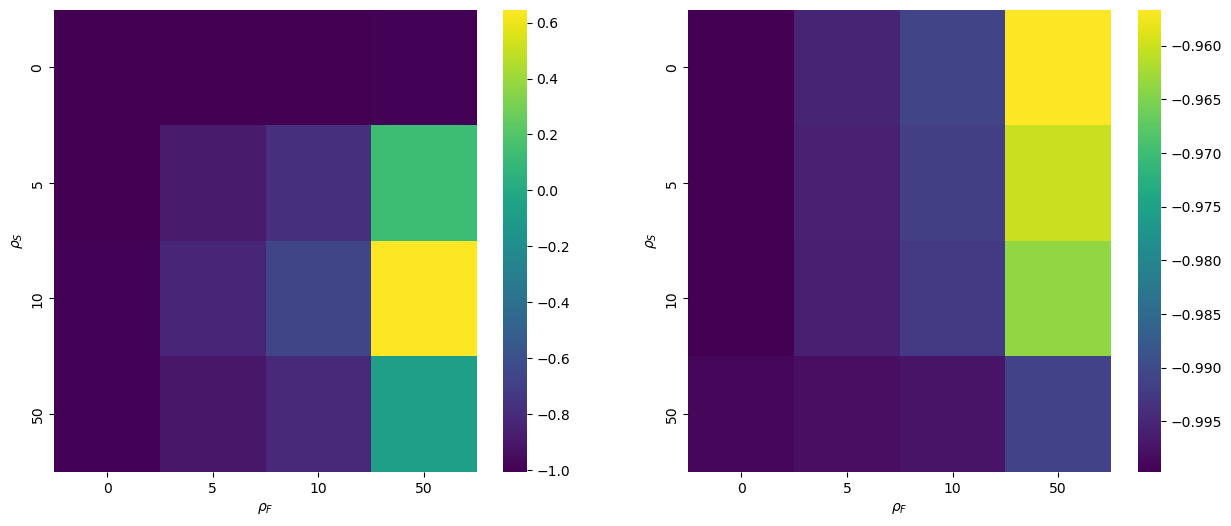

In [191]:
fig, ax =plt.subplots(1,2, figsize=(15,6))

# Plot the heatmaps on the subplots with the same color scale
sns.heatmap(mean_records_off[options[choose_key],:,:], cmap="viridis", ax=ax[0], 
            xticklabels=list(f.flatten()) , yticklabels=list(s.flatten()))
sns.heatmap(mean_records_iv[options[choose_key],:,:], cmap="viridis", ax=ax[1], 
            xticklabels=list(f.flatten()) , yticklabels=list(s.flatten()))

# Set the axis labels to be LaTeX formulas
ax[0].set_xlabel(r"$\rho_F$")
ax[0].set_ylabel(r"$\rho_S$")
ax[1].set_xlabel(r"$\rho_F$")
ax[1].set_ylabel(r"$\rho_S$")

# plt.savefig("./ols_suppdem1.pdf", format='pdf')

Text(792.3131313131312, 0.5, '$\\rho_S$')

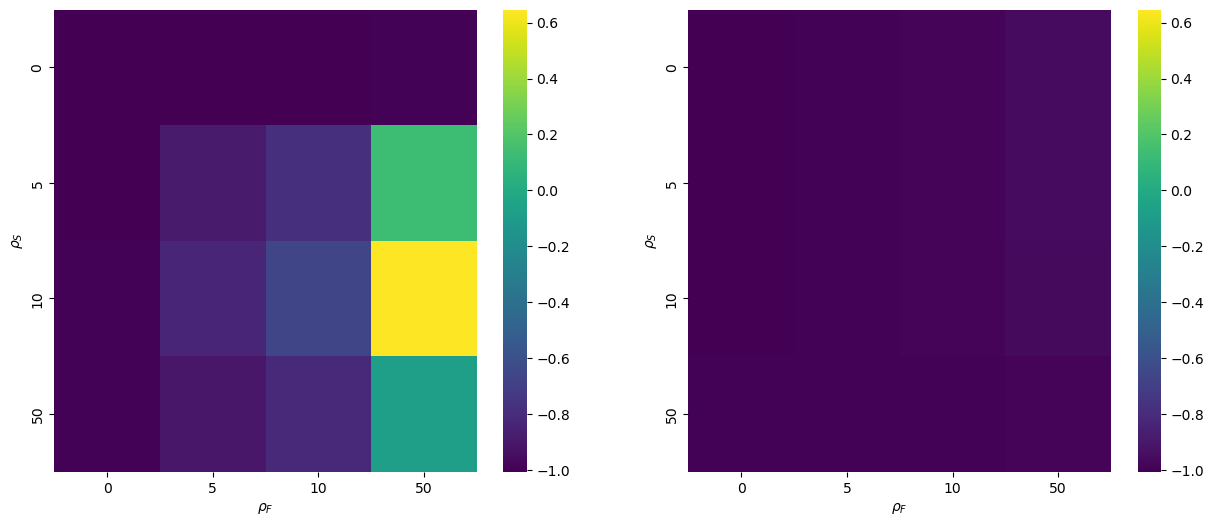

In [192]:
# Calculate the minimum and maximum values for the color scale
min_val = min(mean_records_off[options[choose_key],:,:].min(), mean_records_iv[options[choose_key],:,:].min())
max_val = max(mean_records_off[options[choose_key],:,:].max(), mean_records_iv[options[choose_key],:,:].max())

# Set the size of the figure
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot the heatmaps on the subplots with the same color scale
sns.heatmap(mean_records_off[options[choose_key],:,:], cmap="viridis", ax=ax[0], 
            xticklabels=list(f.flatten()) , yticklabels=list(s.flatten()) , vmin=min_val, vmax=max_val)
sns.heatmap(mean_records_iv[options[choose_key],:,:], cmap="viridis", ax=ax[1], 
            xticklabels=list(f.flatten()) , yticklabels=list(s.flatten()) ,vmin=min_val, vmax=max_val)

# Set the axis labels to be LaTeX formulas
ax[0].set_xlabel(r"$\rho_F$")
ax[0].set_ylabel(r"$\rho_S$")
ax[1].set_xlabel(r"$\rho_F$")
ax[1].set_ylabel(r"$\rho_S$")

# Display the plot
# plt.savefig("./ols_suppdem2.pdf", format='pdf')

## Online

#### OLS/ridge

In [193]:
sp = LinearRegression()
records_on = np.zeros((n_iters, T, len(type_onrec), dim_s_f, dim_s_f))

for e in range(n_iters):
    for t in range(1,T,1):
        for i in range(dim_s_f):
            for j in range(dim_s_f):
                sp.fit(X[e,:t,i,j].reshape((-1,1)), y[e,:t,i,j].reshape((-1,1)))
                records_on[e,t,0,i,j] = sp.coef_[0][0]
                if t>1:
                    records_on[e,t,1,i,j] = sp.score(X[e,:t,i,j].reshape((-1,1)), y[e,:t,i,j].reshape((-1,1)))
                records_on[e,t,2,i,j] = np.abs(records_on[e,t,0,i,j]-beta_star)
                records_on[e,t,3,i,j] = records_on[e,t-1,3,i,j] + (X[e,t,i,j]*(sp.coef_[0][0]-beta_star))**2 
mean_records_on = np.mean(records_on, axis=0)
std_records_on = np.std(records_on, axis=0)

<Axes: >

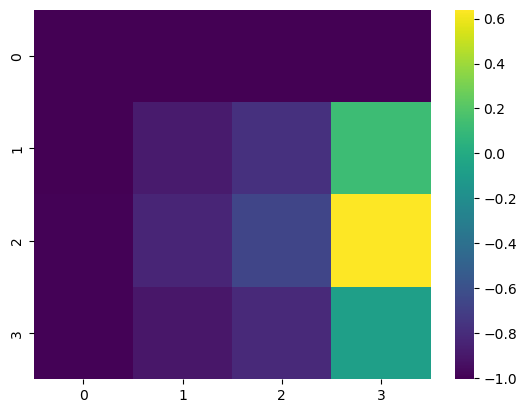

In [194]:
options = {"beta":0, "R2":1, "reg":2, "cumreg":3}
choose_key = "beta"

sns.heatmap(mean_records_on[-1, options[choose_key],:,:], cmap="viridis")
# mean_records_on[-1, options[choose_key],:,:].round(5)

#### IV

In [195]:
def off_2sls_ds(stage1, stage2, Z, X, y):
    stage1.fit(Z, X)
    hatX = stage1.predict(Z)
    stage2.fit(hatX, y)
    haty = stage2.predict(X)
    return stage1, stage2 

In [196]:
# stage1 = LinearRegression()
# stage2 = LinearRegression()
stage1 = Ridge(lamda_IV)
stage2 = Ridge(lamda_IV)

records_on_iv = np.zeros((n_iters, T, len(type_onrec), dim_s_f, dim_s_f))

for e in range(n_iters):
    for t in range(1,T,1):
        for i in range(dim_s_f):
            for j in range(dim_s_f):
                stage1, stage2 = off_2sls_ds(stage1, stage2, Z[e,:t,:], X[e,:t,i,j].reshape((-1,1)), y[e,:t,i,j].reshape((-1,1)))
                records_on_iv[e,t,0,i,j] = stage2.coef_[0][0]
                if t>1:
                    records_on_iv[e,t,1,i,j] = stage2.score(X[e,:t,i,j].reshape((-1,1)), y[e,:t,i,j].reshape((-1,1)))
                records_on_iv[e,t,2,i,j] = np.abs(records_on_iv[e,t,0,i,j]-beta_star)
                records_on_iv[e,t,3,i,j] = records_on_iv[e,t-1,3,i,j] + (X[e,t,i,j]*(records_on_iv[e,t,0,i,j]-beta_star))**2 

mean_records_on_iv = np.mean(records_on_iv[:,:,:,:], axis=0)
std_records_on_iv = np.std(records_on_iv, axis=0)

<Axes: >

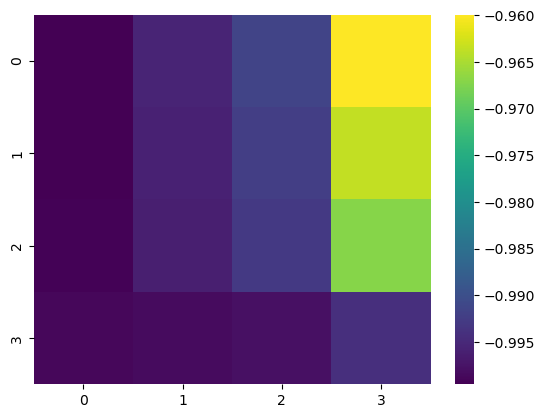

In [197]:
options = {"beta":0, "R2":1, "reg":2, "cumreg":3}
choose_key = "beta"

sns.heatmap(mean_records_on_iv[-1, options[choose_key],:,:], cmap="viridis")
# mean_records_on_iv[-1, options[choose_key],:,:].round(5)

Text(792.3131313131312, 0.5, '$\\rho_S$')

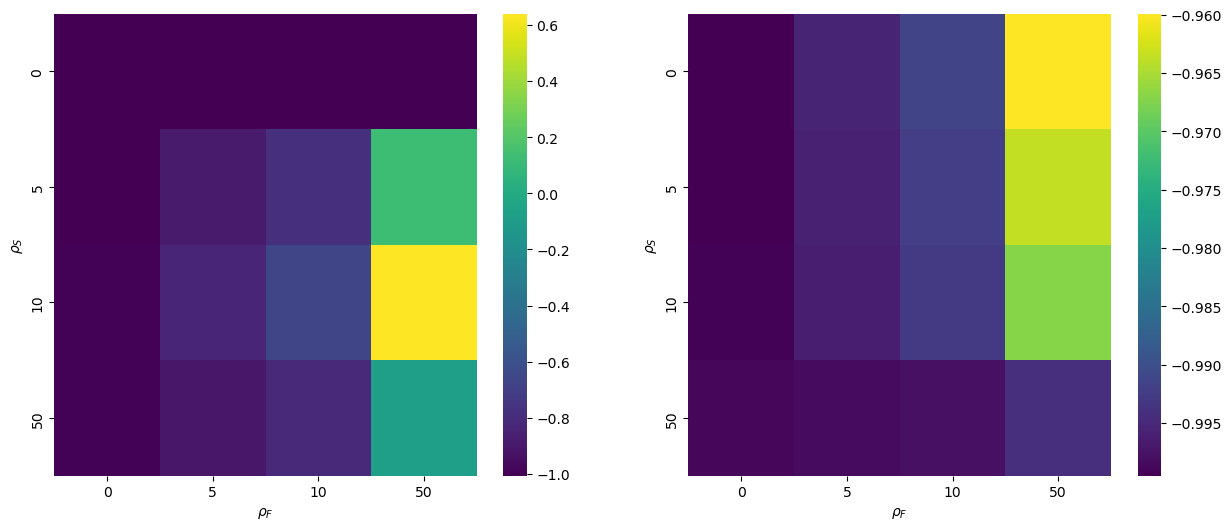

In [198]:
# Set the size of the figure
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot the heatmaps on the subplots with the same color scale
sns.heatmap(mean_records_on[-1,options[choose_key],:,:], cmap="viridis", ax=ax[0], 
            xticklabels=list(f.flatten()) , yticklabels=list(s.flatten()))
sns.heatmap(mean_records_on_iv[-1, options[choose_key],:,:], cmap="viridis", ax=ax[1], 
            xticklabels=list(f.flatten()) , yticklabels=list(s.flatten()))

# Set the axis labels to be LaTeX formulas
ax[0].set_xlabel(r"$\rho_F$")
ax[0].set_ylabel(r"$\rho_S$")
ax[1].set_xlabel(r"$\rho_F$")
ax[1].set_ylabel(r"$\rho_S$")

# Display the plot
# plt.savefig("./online_ols_suppdem1.pdf", format='pdf')

Text(792.3131313131312, 0.5, '$\\rho_S$')

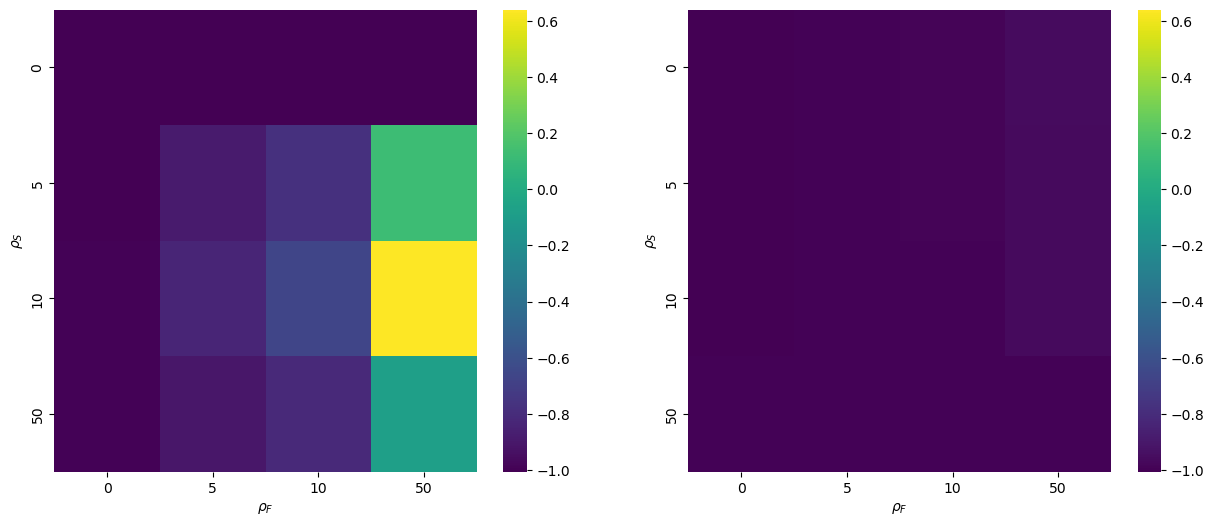

In [199]:
# Calculate the minimum and maximum values for the color scale
min_val = min(mean_records_on[-1,options[choose_key],:,:].min(), mean_records_on_iv[-1, options[choose_key],:,:].min())
max_val = max(mean_records_on[-1,options[choose_key],:,:].max(), mean_records_on_iv[-1, options[choose_key],:,:].max())

# Set the size of the figure
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot the heatmaps on the subplots with the same color scale
sns.heatmap(mean_records_on[-1,options[choose_key],:,:], cmap="viridis", ax=ax[0], 
            xticklabels=list(f.flatten()) , yticklabels=list(s.flatten()) , vmin=min_val, vmax=max_val)
sns.heatmap(mean_records_on_iv[-1, options[choose_key],:,:], cmap="viridis", ax=ax[1], 
            xticklabels=list(f.flatten()) , yticklabels=list(s.flatten()) ,vmin=min_val, vmax=max_val)

# Set the axis labels to be LaTeX formulas
ax[0].set_xlabel(r"$\rho_F$")
ax[0].set_ylabel(r"$\rho_S$")
ax[1].set_xlabel(r"$\rho_F$")
ax[1].set_ylabel(r"$\rho_S$")

# Display the plot
# plt.savefig("./online_ols_suppdem2.pdf", format='pdf')

#### Plot learning curves

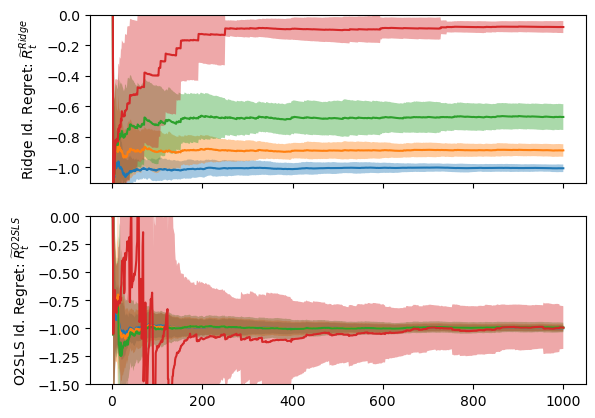

In [204]:
rounds = np.array([t for t in range(1,T+1,1)])
options = {"beta":0, "R2":1, "reg":2, "cumreg":3}
choose_key = "beta"

fig, axarr = plt.subplots(2, sharex=True)
for i in range(dim_s_f):
    reg = mean_records_on[:,options[choose_key],i,i]
    reg_iv = mean_records_on_iv[:,options[choose_key],i,i]
    reg_std = std_records_on[:,options[choose_key],i,i]
    reg_iv_std = std_records_on_iv[:,options[choose_key],i,i]

    axarr[0].plot(rounds, reg) #, color = colors[i])
    axarr[0].fill_between(rounds, reg-reg_std, reg+reg_std, alpha=0.4)
    axarr[0].set_ylabel(r"Ridge Id. Regret: $\widetilde{R}^{Ridge}_t$")
    axarr[0].set_ylim([-1.1, 0])  # Set the y-limits for the first subplot

    axarr[1].plot(rounds, reg_iv)#, color=colors[1])
    axarr[1].fill_between(rounds, reg_iv-reg_iv_std, reg_iv+reg_iv_std, alpha=0.4)
    axarr[1].set_ylabel(r"O2SLS Id. Regret: $\widetilde{R}^{O2SLS}_t$")
    axarr[1].set_ylim([-1.5, 0])  # Set the y-limits for the second subplot

plt.show()

